### Initialize the environment

In [1]:
import theano
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
src_dir='../src' # source directory
run_dir_prefix='../MDBN_run/AML_Batch_' # directory with the results of previous runs
data_dir='../data' # directory with the data files

In [3]:
import sys
sys.path.insert(0, src_dir)
import rbm
import MDBN
import main

### Load the experiment results

In [4]:
run=0
uuid='eb6856a251bb8680da6593de98db7b5a'
timestamp='20170220T205506' # specify the date and time of the run in the format YYYYmmddTHHMMSS
run_dir=run_dir_prefix+timestamp
runfile='Exp_%s_run_%s.npz' % (uuid, run) # location of the experiment results
mdbn = MDBN.MDBN()
config, dbn_dict = mdbn.load_network(runfile, run_dir)

In [5]:
config

{u'dbns': {u'GE': {u'batchSize': 1,
   u'datafile': u'AML/AML_gene_expression_table2.csv.gz',
   u'epochs': [20, 800],
   'inputNodes': 19937,
   u'k': 1,
   u'lambdas': [0.0, 1.0],
   u'layersNodes': [400, 40],
   u'lr': [0.0005, 0.1],
   u'persistent': False},
  u'ME': {u'batchSize': 1,
   u'datafile': u'AML/AML_miRNA_Seq_table2.csv.gz',
   u'epochs': [20],
   'inputNodes': 559,
   u'k': 10,
   u'lambdas': [0.0, 0.1],
   u'layersNodes': [40],
   u'lr': [0.005],
   u'persistent': False},
  u'SM': {u'batchSize': 1,
   u'datafile': u'AML/AML_somatic_mutations_table2.csv.gz',
   u'epochs': [20, 800],
   'inputNodes': 1686,
   u'k': 1,
   u'lambdas': [0.0, 0.1],
   u'layersNodes': [200, 20],
   u'lr': [0.01, 0.1],
   u'persistent': False}},
 u'name': u'aml_config_20_1_05.json',
 u'p': 0.5,
 u'pathways': [u'ME', u'GE', u'SM'],
 u'runs': 4,
 u'seed': 1234,
 u'top': {u'batchSize': 1,
  u'epochs': [800, 800],
  'inputNodes': 100,
  u'k': 1,
  u'layersNodes': [24, 3],
  u'lr': [0.1, 0.1],
  u'

### Load the data

In [6]:
datafiles = main.prepare_TCGA_datafiles("AML",config,data_dir)

In [7]:
import utils
real_set, _ = utils.load_n_preprocess_data(datafiles['SM'],datadir=data_dir)

#### Compute the joint layer components

In [8]:
dbn_output_list=[]
for key in config['pathways']:
    dbn_output, _ = dbn_dict[key].MLP_output_from_datafile(datafiles[key], datadir=data_dir)
    dbn_output_list.append(dbn_output)

In [10]:
dbn_output = dbn_dict['SM'].get_output(theano.shared(np.zeros(real_set.get_value().shape,
                                                                        dtype=theano.config.floatX),borrow=True))
#dbn_output = np.zeros((real_set.get_value().shape[0],20),dtype=theano.config.floatX)

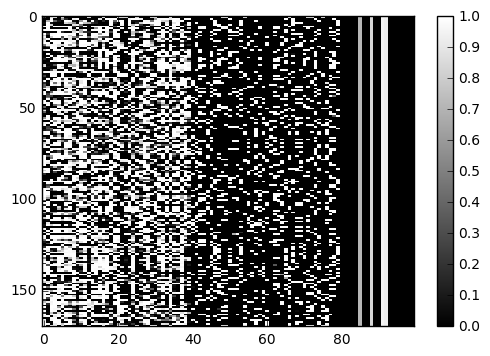

In [11]:
joint_layer = np.hstack((dbn_output_list[0],dbn_output_list[1],dbn_output))
#joint_layer = np.concatenate(dbn_output_list,axis=1)
plt.imshow(joint_layer, interpolation='none', cmap='gray')
plt.axis('tight')
plt.colorbar()

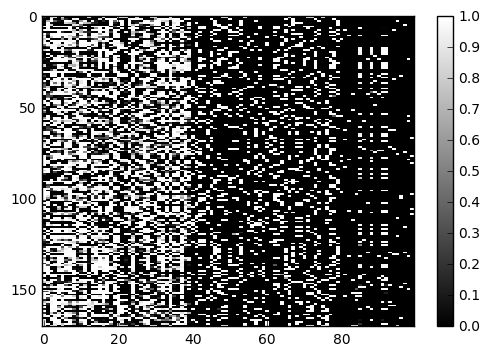

In [12]:
real_joint_layer = np.concatenate(dbn_output_list,axis=1)
plt.imshow(real_joint_layer, interpolation='none', cmap='gray')
plt.axis('tight')
plt.colorbar()

In [13]:
top_output = dbn_dict['top'].get_output(joint_layer)

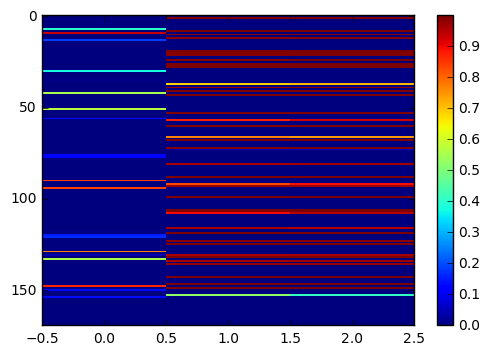

In [14]:
plt.imshow(top_output, interpolation='none')
plt.axis('tight')
plt.colorbar()

### Gibbs sampling of the top layer and prop down w/ ancestral sampling

We iterate the reconstruction 50 times

In [15]:
reload(rbm)

<module 'rbm' from '../src/rbm.pyc'>

In [16]:
top_dbn_rbm0 = dbn_dict['top'].rbm_layers[0]
top_dbn_rbm1 = dbn_dict['top'].rbm_layers[1]

In [17]:
h1 = theano.tensor.matrix('h1')
rec_joint_layer = top_dbn_rbm0.sample_v_given_h(h1)
rec_joint_fn = theano.function([h1], rec_joint_layer)

In [18]:
for i in range(50):
    top_output = dbn_dict['top'].get_output(joint_layer)
    sampled_hidden_layer = top_dbn_rbm1.reverse_sampling(1,theano.shared(top_output,borrow=True),gibbs_steps=50)
    sampled_joint_layer = rec_joint_fn(sampled_hidden_layer[0])
    joint_layer = np.concatenate([joint_layer[:,:80],sampled_joint_layer[2][:,80:100]],axis=1)

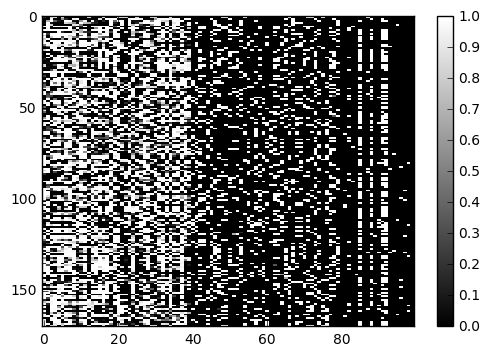

In [19]:
plt.imshow(joint_layer, cmap='gray',interpolation='none')
plt.axis('tight')
plt.colorbar()

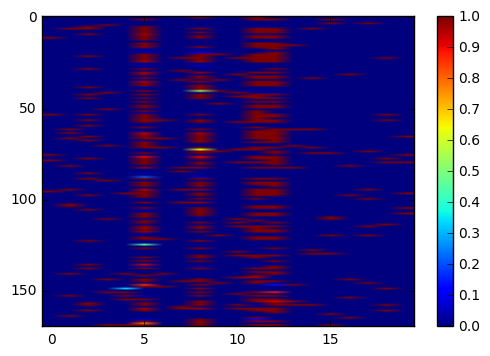

In [20]:
plt.imshow(np.sqrt(np.square(real_joint_layer[:,80:100]-joint_layer[:,80:100])))
plt.axis('tight')
plt.colorbar()

### Propagate down on the unimodal DBN

In [21]:
dbn_rbm1 = dbn_dict['SM'].rbm_layers[1]

In [22]:
sampled_hid_layer = dbn_rbm1.reverse_sampling(1,theano.shared(joint_layer[:,80:100],borrow=True))

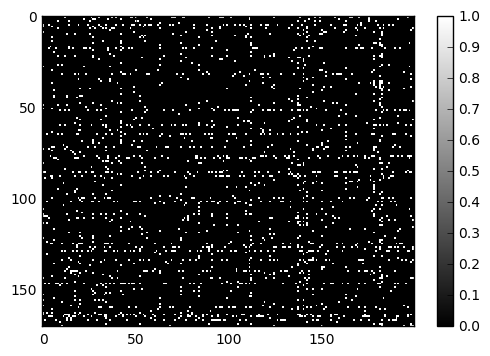

In [23]:
plt.imshow(sampled_hid_layer[0], interpolation='none', cmap='gray')
plt.axis('tight')
plt.colorbar()

In [24]:
dbn_rbm0 = dbn_dict['SM'].rbm_layers[0]

In [25]:
vis_layer = dbn_rbm0.sample_v_given_h(h1)
vis_fn = theano.function([h1], vis_layer)

In [26]:
_, _, sampled_vis_layer = vis_fn(sampled_hid_layer[0])

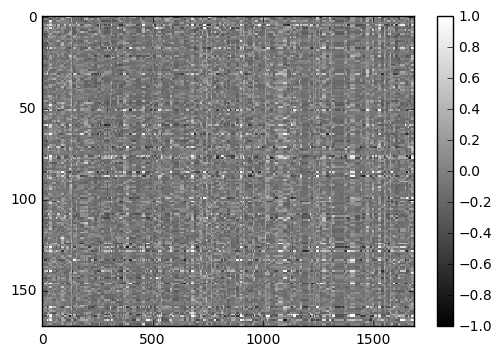

In [36]:
plt.imshow(sampled_vis_layer,interpolation='none',cmap='gray',clim=(-1,1))
plt.axis('tight')
plt.colorbar()

### Compare reconstructed and actual data

/Users/gluca/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/axes/_axes.py:5907: UserWarning: 2D hist input should be nsamples x nvariables;
 this looks transposed (shape is 170 x 1686)
  '(shape is %d x %d)' % inp.shape[::-1])


([array([  0.,   6.,  74.,  88.,   2.,   0.,   0.,   0.,   0.,   0.]),
  array([  0.,   6.,  74.,  88.,   2.,   0.,   0.,   0.,   0.,   0.]),
  array([  0.,   6.,  74.,  88.,   2.,   0.,   0.,   0.,   0.,   0.]),
  array([  0.,   4.,  77.,  77.,  12.,   0.,   0.,   0.,   0.,   0.]),
  array([  0.,   6.,  74.,  88.,   2.,   0.,   0.,   0.,   0.,   0.]),
  array([  0.,   5.,  75.,  88.,   2.,   0.,   0.,   0.,   0.,   0.]),
  array([  0.,   6.,  74.,  88.,   2.,   0.,   0.,   0.,   0.,   0.]),
  array([   1.,    5.,   24.,  107.,   32.,    1.,    0.,    0.,    0.,    0.]),
  array([  0.,   6.,  74.,  88.,   2.,   0.,   0.,   0.,   0.,   0.]),
  array([   1.,    3.,   31.,  107.,   25.,    3.,    0.,    0.,    0.,    0.]),
  array([   0.,    5.,  104.,   50.,    7.,    4.,    0.,    0.,    0.,    0.]),
  array([   0.,    5.,  104.,   50.,    7.,    4.,    0.,    0.,    0.,    0.]),
  array([   0.,    5.,  104.,   50.,    7.,    4.,    0.,    0.,    0.,    0.]),
  array([  1.,   3.,  96., 

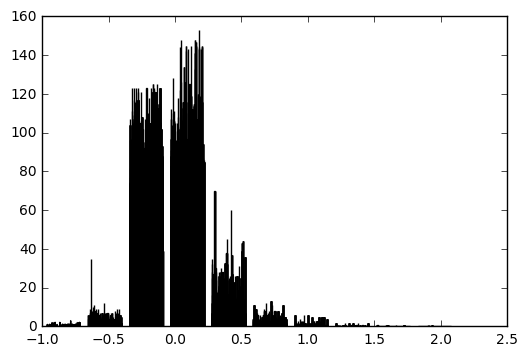

In [33]:
#plt.imshow(np.sqrt(np.square(real_set.get_value()-sampled_vis_layer)),interpolation='none',clim=(0,2))
#plt.axis('tight')
#plt.colorbar()
plt.hist(sampled_vis_layer)

([array([ 169.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
  array([ 169.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
  array([ 169.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
  array([ 154.,    0.,   16.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]),
  array([ 169.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
  array([ 169.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
  array([ 169.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
  array([ 122.,   48.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]),
  array([ 169.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
  array([ 127.,   38.,    5.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]),
  array([ 169.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
  array([ 169.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
  array([ 169.,    0.,    0.

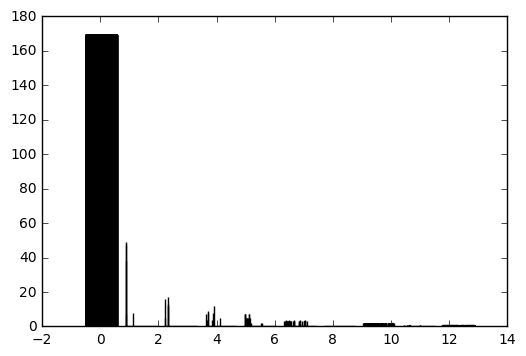

In [34]:
plt.hist(real_set.get_value())

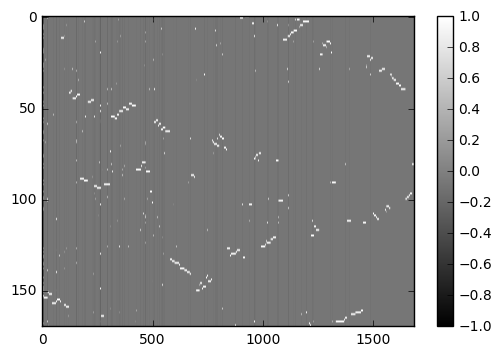

In [35]:
plt.imshow(real_set.get_value(),cmap='gray',clim=(-1,1))
plt.axis('tight')
plt.colorbar()

In [81]:
c = []
d = []
rss = 0
tss = 0
for i in range(170):
    rss = np.sum(np.square(real_set.get_value()[i]-sampled_vis_layer[i])[0])
    tss = np.sum(np.square(real_set.get_value()[i]-np.mean(real_set.get_value()[0]))[0])
    if rss/tss < 1.0:
        c.append(rss/tss)
    else:
        if rss/tss < 15.0:
            d.append(rss/tss)
        else:
            print i, rss/tss

126 20.51
128 19.0253


(array([ 52.,  15.,  17.,   4.,   6.,   5.,   5.,   5.,   6.,   4.]),
 array([  1.79936629e-04,   9.47924645e-02,   1.89404992e-01,
          2.84017520e-01,   3.78630048e-01,   4.73242576e-01,
          5.67855104e-01,   6.62467632e-01,   7.57080160e-01,
          8.51692687e-01,   9.46305215e-01]),
 <a list of 10 Patch objects>)

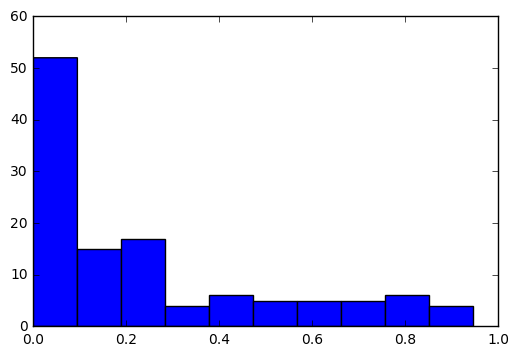

In [82]:
plt.hist(c)

In [83]:
np.mean(c)

0.24639156

In [87]:
len(c)

119

(array([ 16.,  12.,   4.,   2.,   2.,   2.,   3.,   2.,   3.,   3.]),
 array([ 1.02521408,  1.73215197,  2.43908987,  3.14602777,  3.85296566,
         4.55990356,  5.26684146,  5.97377936,  6.68071725,  7.38765515,
         8.09459305]),
 <a list of 10 Patch objects>)

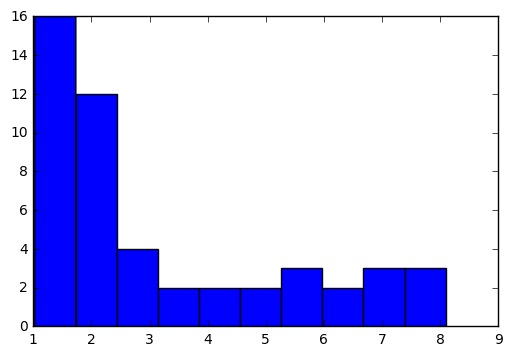

In [84]:
plt.hist(d)

In [85]:
np.mean(d)

3.231843

In [86]:
len(d)

49